In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Problem 1a

# Data Exploration

In [2]:
import pandas as pd
train = pd.read_csv("BRCA-prognosis-train.csv")
train

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (641,647,649,651,653,654,655,656,657,658,659,661) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut,outcome
0,0.6522,-1.0002,0.2878,0.4661,-1.1925,1.2016,-0.7379,-0.5657,0.5885,1.0009,...,0,0,0,0,0,0,0,0,0,0
1,-1.1329,2.7485,-0.7175,0.9446,-0.2574,-1.2881,-0.9623,-0.4673,0.2962,-0.9181,...,0,0,0,0,0,0,0,0,0,1
2,-0.6247,0.9146,-0.0536,-0.0933,0.0326,-1.7125,-1.0493,-0.6886,-0.5311,-1.7056,...,0,0,0,0,0,0,0,0,0,0
3,0.5877,-2.2261,2.4252,-0.6472,-1.7071,0.8207,-0.4278,3.4991,-0.5951,-1.0470,...,0,0,0,0,0,0,0,0,0,0
4,-0.2048,-1.2539,-1.7408,0.2214,-0.0545,0.9722,0.8895,0.9785,-0.3633,-1.1611,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,-0.8468,0.4818,0.6131,0.0600,-0.6060,1.7714,0.8917,0.1010,-0.8821,-0.7944,...,0,0,0,0,0,0,0,0,0,1
1400,-0.1844,0.0005,0.3751,-0.7222,-1.8560,0.7996,0.1025,0.7319,2.6620,-0.0314,...,0,0,0,0,0,0,0,0,0,0
1401,1.4376,-0.3174,1.3291,0.4604,0.7625,-0.3105,-2.8114,0.1046,0.7327,0.1248,...,0,0,0,0,0,0,0,0,0,0
1402,-1.2448,-2.2417,0.5508,0.8508,-0.6159,1.5829,0.0555,1.3599,-0.5648,-0.5968,...,0,0,0,0,0,0,0,0,0,1


<function matplotlib.pyplot.show(close=None, block=None)>

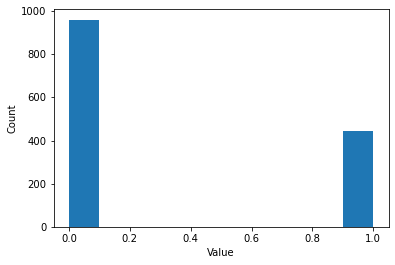

In [3]:
#let's see the distribution of the outcome variable
train["outcome"].value_counts()
plt.hist(train["outcome"])
plt.xlabel("Value")
plt.ylabel("Count")
plt.show

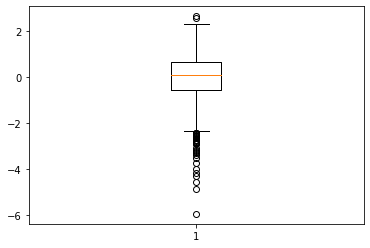

In [4]:
#Let's also pick a few random variables and check for outliers
plt.boxplot(train["pten"], showfliers = True, notch = False) #many outliers, but highly concentrated at 0

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe8d83d20a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe8d83d2790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe8d83bfcd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe8d83d2d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe90bc60100>],
 'means': []}

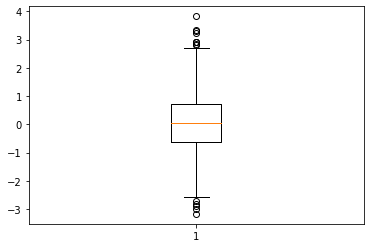

In [5]:
plt.boxplot(train["atm"], showfliers = True, notch = False) #again, quite a few outliers

In sum, we see that there is a class imbalance in this data, which tells us that accuracy might not be particularly helpful as a metric. In addition, there are a number of outliers which require attention. All this will play into the creation of the model.

# Data Preprocessing

First let's convert any and all strings to integers

In [6]:
for col in train.columns:
    train[col] = pd.to_numeric(train[col], errors='coerce').fillna(1).astype(np.int64)
    #this replaces all strings in the mut columns with 1

In [7]:
#this column is all 0 and provides no information
train.drop("stmn2_mut", axis = 1, inplace = True)

# Problem 1B

For this feed forward network, I plan to start shallow and add more layers if necessary. I think to start I'd like to have two hidden layers, reducing data first from 661 to a more reasonable number, and reducing to 1 at the finish. I plan to use batch normalization as well after each layer to help with predictive power. 

Given that there is a large number of features, some type of regularization is likely necessary. I plan to use a dropout layer to help reduce overfitting in addition. (Note: early stopping was used in one iteration of model and dropped)

I plan to use cross-entropy loss. 

Hyperparameters to optimize:
- Dropout Rate
- Learning Rate
- Batch size
- Epochs of training

I will keep a history of revisions to the model and hyperparameters below. 

# Train Test Split

In [8]:
dt_train, dt_val = train_test_split(train, test_size=0.2, random_state=2634)

X_train = dt_train.drop(labels=["outcome"],axis=1)
y_train = dt_train["outcome"]
X_val = dt_val.drop(labels=["outcome"],axis=1)
y_val = dt_val["outcome"]

print(f"number of features = {X_train.shape[1]}")
print(f"number of classes = {y_train.unique().shape[0]}")

number of features = 661
number of classes = 2


# Standardize Input

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

# Parameters

In [10]:
epochs = 75
batch_size = 64
learning_rate = 0.001

# Problem 1c

# Load Data

In [11]:
from torch.utils.data import Dataset, DataLoader
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

#val_data = TrainData(torch.FloatTensor(X_val), 
                     #torch.FloatTensor(y_val))
    
## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

val_data = TestData(torch.FloatTensor(X_val))

# Initialize Loaders


In [12]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

Hyperparameter/Model Tuning History:

Model 1:
- 3 layers 661-128-1
- Dropout
- LR 0.01
- Epochs 50
- Batch Size: 128

Model 2:
- Batch size reduced to 64
- Added L2 regularization in optimization function

Model 3
- Regularization removed in optim function
- Switched from SGD to ADAM in pytorch optim

Model 4
- Epochs increased to 100

M5
- Dropout probability increased to 0.2
- Val AUC 0.65

M6
- Dropout increased 0.3
- Val AUC 0.633

M7
- Added 3rd layer to model

M8
- Reduced epochs to 75

M9 
- Loss function switched to BCE w/ Logit loss (combines cross-entropy inside sigmoid)


# Define Model

In [13]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()        # Number of input features is 661.
        self.layer_1 = nn.Linear(661, 128) 
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [14]:
device = "cpu"

In [15]:
model = BinaryClassifier()
model.to(device)
print(model)

criterion = nn.BCEWithLogitsLoss() #chosen bc cross-entropy + sigmoid 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

BinaryClassifier(
  (layer_1): Linear(in_features=661, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [16]:
model.train() #remember to set this to eval later
for e in range(1, epochs+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad() #setting grads
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        #acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step() #step
        
        epoch_loss += loss.item()

        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f}')

Epoch 001: | Loss: 0.66595
Epoch 002: | Loss: 0.43604
Epoch 003: | Loss: 0.27961
Epoch 004: | Loss: 0.15025
Epoch 005: | Loss: 0.07786
Epoch 006: | Loss: 0.03996
Epoch 007: | Loss: 0.02743
Epoch 008: | Loss: 0.02049
Epoch 009: | Loss: 0.01448
Epoch 010: | Loss: 0.01132
Epoch 011: | Loss: 0.00999
Epoch 012: | Loss: 0.00681
Epoch 013: | Loss: 0.00558
Epoch 014: | Loss: 0.00554
Epoch 015: | Loss: 0.00424
Epoch 016: | Loss: 0.00425
Epoch 017: | Loss: 0.00405
Epoch 018: | Loss: 0.00368
Epoch 019: | Loss: 0.00319
Epoch 020: | Loss: 0.00373
Epoch 021: | Loss: 0.00266
Epoch 022: | Loss: 0.00188
Epoch 023: | Loss: 0.00215
Epoch 024: | Loss: 0.00220
Epoch 025: | Loss: 0.00164
Epoch 026: | Loss: 0.00193
Epoch 027: | Loss: 0.00187
Epoch 028: | Loss: 0.00169
Epoch 029: | Loss: 0.00140
Epoch 030: | Loss: 0.00129
Epoch 031: | Loss: 0.00145
Epoch 032: | Loss: 0.00127
Epoch 033: | Loss: 0.00106
Epoch 034: | Loss: 0.00090
Epoch 035: | Loss: 0.00104
Epoch 036: | Loss: 0.00121
Epoch 037: | Loss: 0.00099
E

# Problem 1d 
# Testing

In [17]:
test_loader = DataLoader(dataset=val_data, batch_size=1)

In [18]:
y_pred_list = []
#epoch_loss = 0
#epoch_acc = 0
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred) #for probabilities we will just stop the loop here
        
        #loss = criterion(y_pred, y_batch.unsqueeze(1))
        #acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        #epoch_loss += loss.item()
        #epoch_acc += acc.item()
        #print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(test_loader):.5f} | Acc: {epoch_acc/len(test_loader):.3f}')
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [19]:
confusion_matrix(y_val, y_pred_list)

array([[163,  41],
       [ 48,  29]])

In [20]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, y_pred_list)

0.587821492233257

In [21]:
print(classification_report(y_val, y_pred_list))

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       204
           1       0.41      0.38      0.39        77

    accuracy                           0.68       281
   macro avg       0.59      0.59      0.59       281
weighted avg       0.67      0.68      0.68       281



# Problem 1E

In [22]:
test = pd.read_csv("BRCA-prognosis-test.csv")
test

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,-0.6113,-0.4112,-0.5326,1.2881,-1.3982,-0.2587,0.3170,-0.1585,-0.9302,-0.2004,...,0,0,0,G12S,0,0,0,0,0,0
1,-0.7632,0.6394,1.0946,-0.7267,-1.1607,1.2332,-0.6189,0.3389,3.3672,1.7262,...,0,0,0,0,0,0,0,0,0,0
2,-0.4674,-0.4817,1.0418,0.6514,0.5839,-0.1902,-0.1550,-1.1869,-0.6927,1.4632,...,0,0,0,0,0,0,0,0,0,0
3,1.2946,0.7721,-0.9238,0.3801,-0.3273,-1.1697,0.7206,1.8837,-1.4707,-0.6701,...,0,0,0,0,0,0,0,0,0,0
4,-1.0671,-0.2272,0.5382,-1.4913,2.7068,-0.8004,-0.7550,1.9918,-0.2418,-0.9464,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.1113,-0.9719,-1.3743,0.5981,0.0933,-0.6940,0.1871,0.1299,1.5912,-1.4806,...,0,0,0,0,0,0,0,0,0,0
496,1.0041,-1.2991,-0.3390,-0.9913,0.9715,-1.9011,0.0309,-0.8254,0.1091,0.6994,...,0,0,0,0,0,0,0,0,0,0
497,-1.1469,0.4460,0.2880,-0.9857,-0.6334,-0.9991,0.2086,1.3829,-0.1830,0.0712,...,0,0,0,0,0,0,0,0,0,0
498,-0.7404,-0.6993,-1.0944,-1.2068,-0.9220,1.5662,0.8884,-0.1025,-1.6279,-0.9392,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#all our preprocessing the same
for col in test.columns:
    test[col] = pd.to_numeric(test[col], errors='coerce').fillna(1).astype(np.int64)
    #this replaces all strings in the mut columns with 1
    
test.drop("stmn2_mut", axis = 1, inplace = True)

#scaling

test = scaler.fit_transform(test)


In [24]:
test.shape #same dimensions
#loading data

test = TestData(torch.FloatTensor(test))

test_loader = DataLoader(dataset=test, batch_size=1)

In [25]:
probabilities = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        probabilities.append(y_test_pred)

In [26]:
probabilities[1]

tensor([[0.9998]])

In [27]:
#extracting probabilities as ints from the tensors
probs = [x.numpy() for x in probabilities]
probs = [probs[x][0][0] for x in range(len(probs))]
    

In [28]:
#creating file from list "probs"

import csv
with open('f0036rd_prediction.csv', 'w', newline = '') as csvfile:
    my_writer = csv.writer(csvfile, delimiter = ' ')
    my_writer.writerow(probs)

# Problem 2

In [29]:
import pandas as pd
cancer = pd.read_csv("five-cancers-gene-expression.csv")

cancer

,Patient,Cancer,gene_13968,gene_18617,gene_20131,gene_12738,gene_5337,gene_20496,gene_3408,gene_15234,...,gene_4911,gene_4915,gene_521,gene_8588,gene_7758,gene_7221,gene_8787,gene_12582,gene_19923,gene_7505
0,sample_100,BRCA,8.591709,0.0,7.092408,9.142789,5.805636,7.033654,9.370833,5.209453,...,8.238725,9.715028,8.106783,0.341075,9.342075,8.044028,0.00000,0.0,0.000000,0.616640
1,sample_102,BRCA,8.801388,0.0,5.891225,8.094901,3.039454,5.237969,9.180374,4.675483,...,5.235980,8.728067,7.949056,0.366140,9.433381,5.422445,0.00000,0.0,2.632198,9.340010
2,sample_111,BRCA,8.612400,0.0,6.125393,7.892027,4.830783,5.890634,9.768285,5.335144,...,6.274644,9.391233,7.007846,0.000000,9.637172,6.409890,0.00000,0.0,0.412294,9.418873
3,sample_114,BRCA,8.293775,0.0,5.747242,8.353469,3.768322,5.979115,9.321678,6.105724,...,8.646094,9.354020,7.111772,0.000000,9.209232,8.052677,0.00000,0.0,0.000000,8.573837
4,sample_118,BRCA,8.776821,0.0,7.026391,7.372264,3.824371,5.639357,9.588062,5.239612,...,10.725682,9.139298,8.196587,0.000000,9.473982,4.245861,0.00000,0.0,0.273814,9.252138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,sample_9,PRAD,7.499455,0.0,4.953819,8.387251,5.960875,3.314972,9.575887,6.062892,...,3.595014,10.122841,2.635987,0.724214,9.816036,1.204141,0.00000,0.0,5.098108,11.078831
746,sample_90,PRAD,8.203402,0.0,5.574053,8.475474,2.212320,4.580477,8.733324,7.489286,...,4.065917,9.722710,2.212320,0.000000,9.099471,6.724991,0.00000,0.0,0.000000,10.380374
747,sample_91,PRAD,8.278584,0.0,5.918167,7.897331,4.232231,3.928039,8.348648,6.776630,...,5.962177,9.900328,5.174750,0.000000,9.326582,8.458357,0.00000,0.0,0.000000,12.146238
748,sample_95,PRAD,8.240820,0.0,5.603068,7.973227,1.957989,3.537793,9.373994,5.225965,...,1.288418,9.842309,3.424600,0.000000,9.055936,6.034674,1.05797,0.0,2.413540,11.684416


In [30]:
cancer.Cancer.value_counts()
cancer.Cancer.replace(["BRCA","LUAD","KIRC","PRAD","COAD"],[1,2,3,4,5], inplace = True)
cancer.Cancer.value_counts()

cancer.drop("Patient", axis = 1, inplace = True)
cancer.Patient

AttributeError: 'DataFrame' object has no attribute 'Patient'

# Problem 2a

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2)
tsne_results = tsne.fit_transform(cancer)

cancer["tsne-1"] = tsne_results[:,0]
cancer["tsne-2"] = tsne_results[:,1]

<AxesSubplot:xlabel='tsne-1', ylabel='tsne-2'>

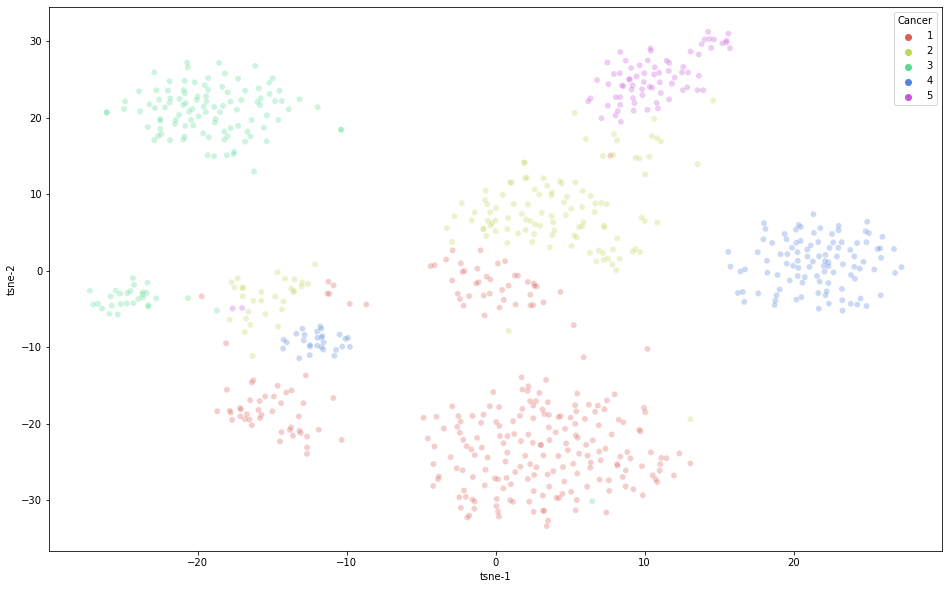

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-1", y="tsne-2",
    hue="Cancer",
    palette=sns.color_palette("hls", 5),
    data=cancer,
    legend="full",
    alpha=0.3
)

I notice a distinct clustering based on these two axes. There appear to be 5 primary clusters well seperated and a pseudo-cluster to the mid-left of the graph - perhaps some confusion?

# Problem 2b

Perplexity: 10 LR: 50


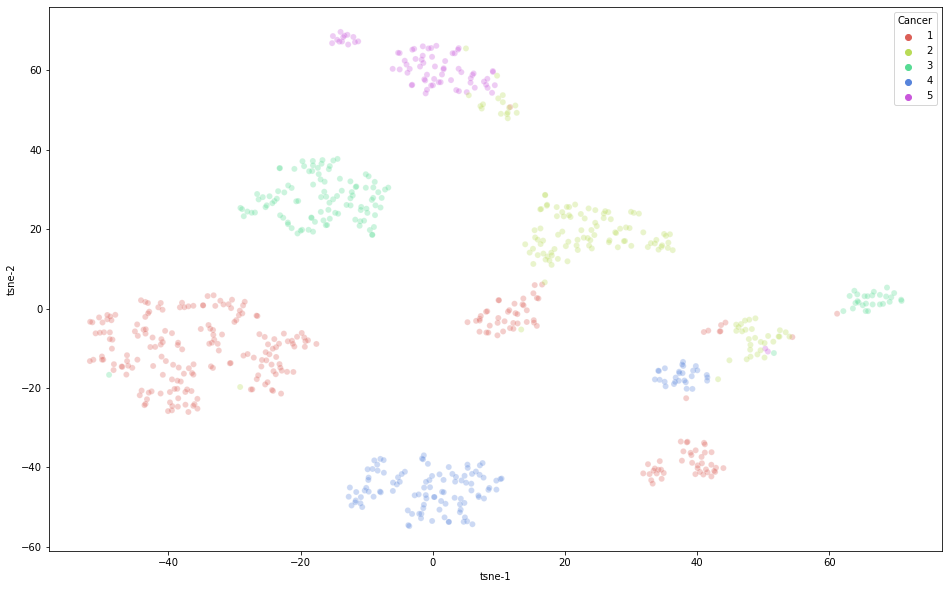

Perplexity: 10 LR: 200


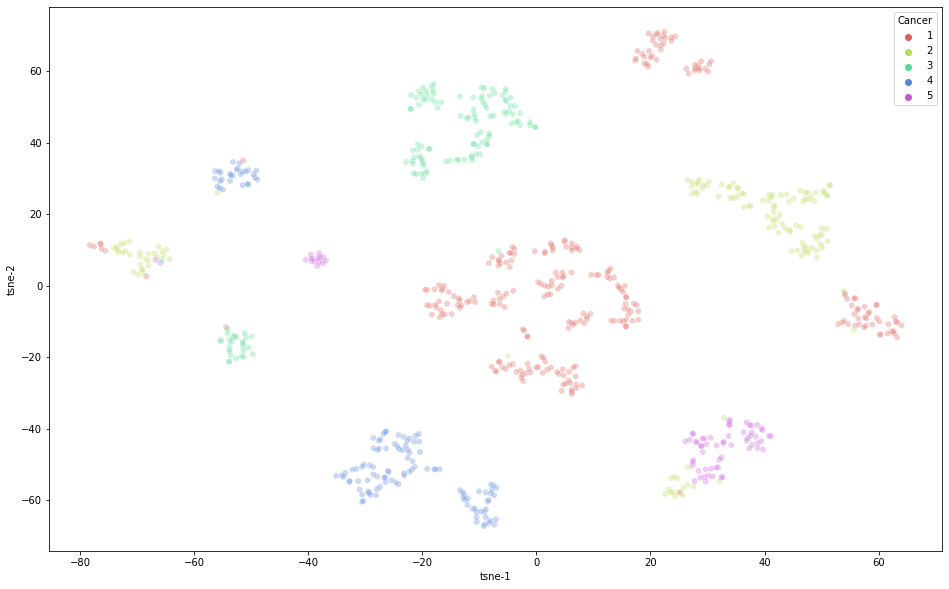

Perplexity: 10 LR: 500


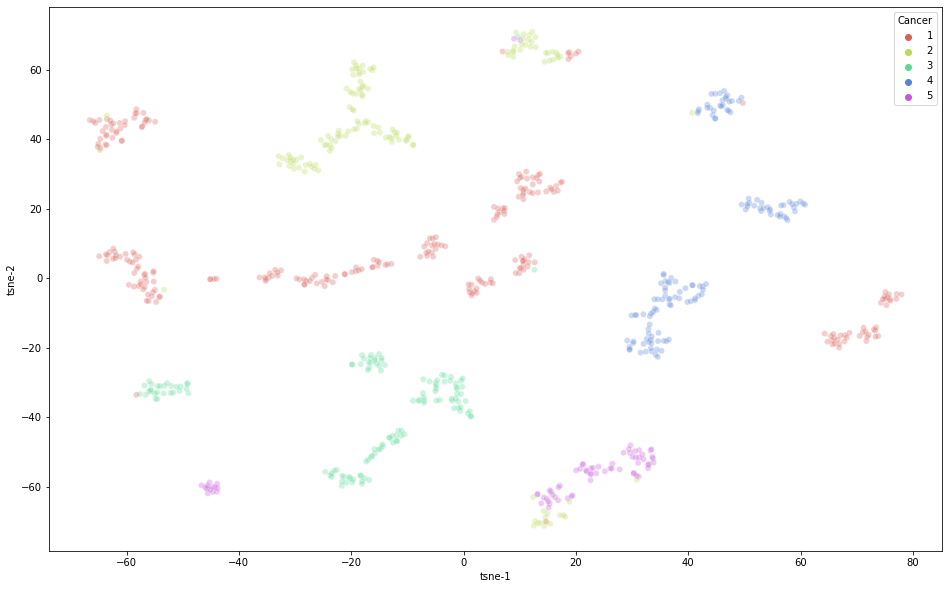

Perplexity: 20 LR: 50


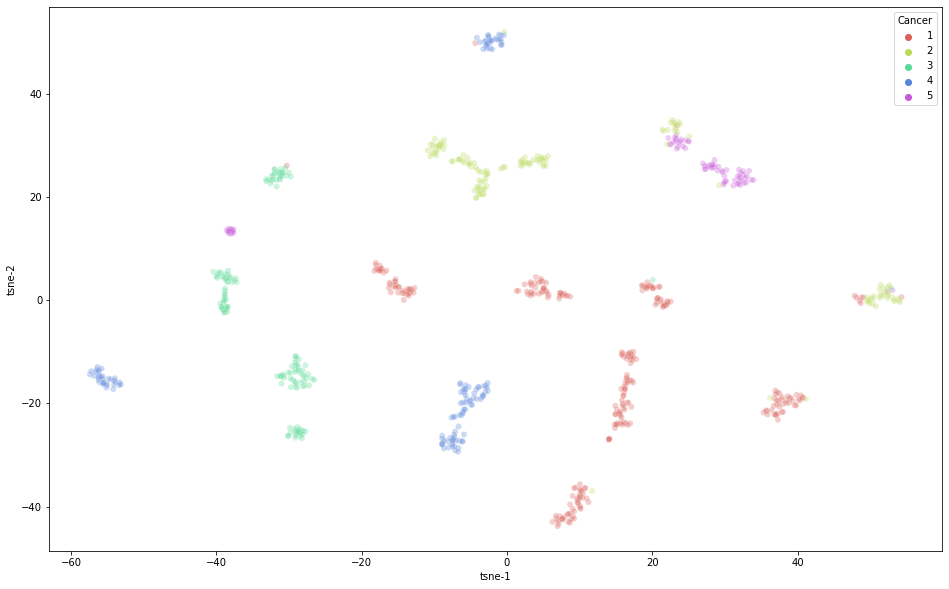

Perplexity: 20 LR: 200


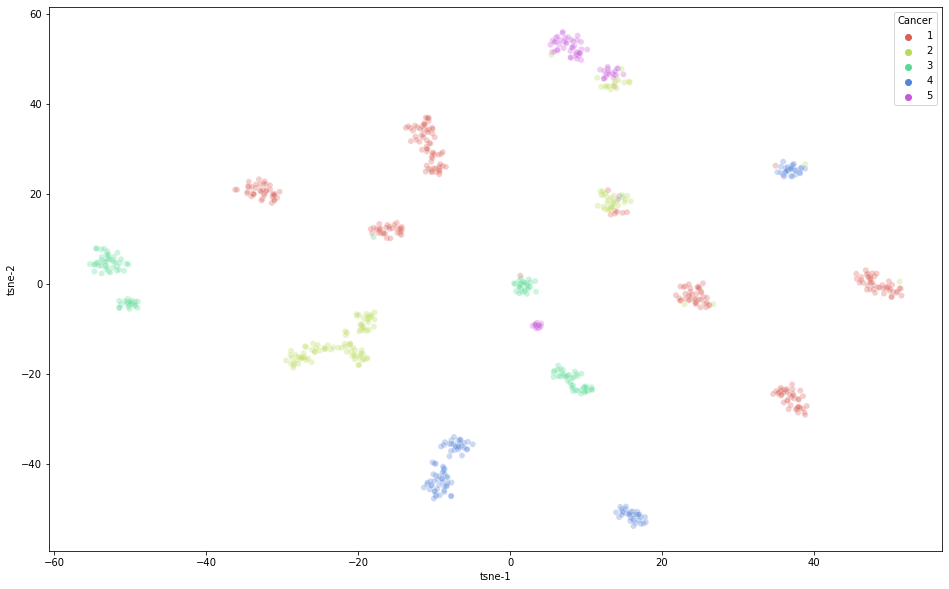

Perplexity: 20 LR: 500


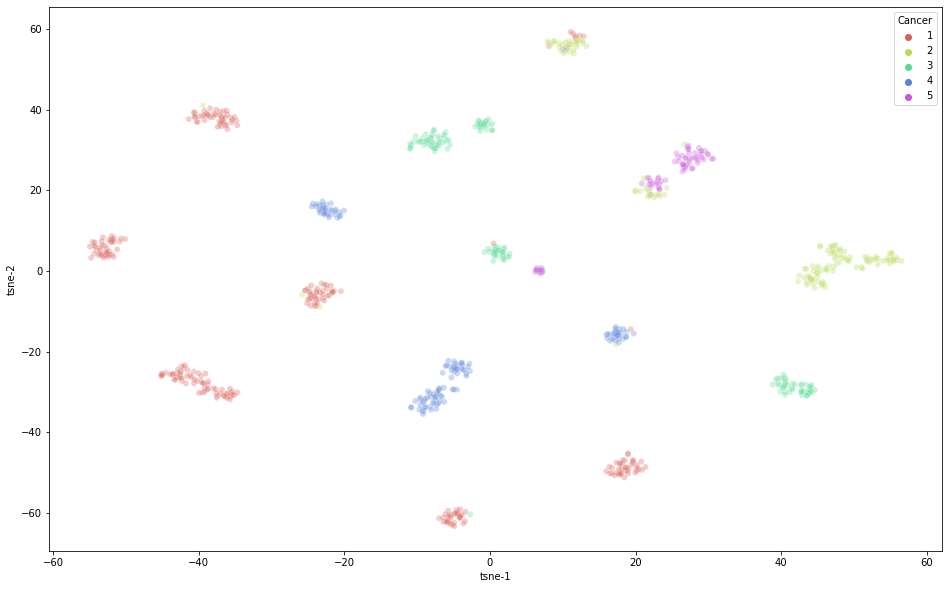

Perplexity: 30 LR: 50


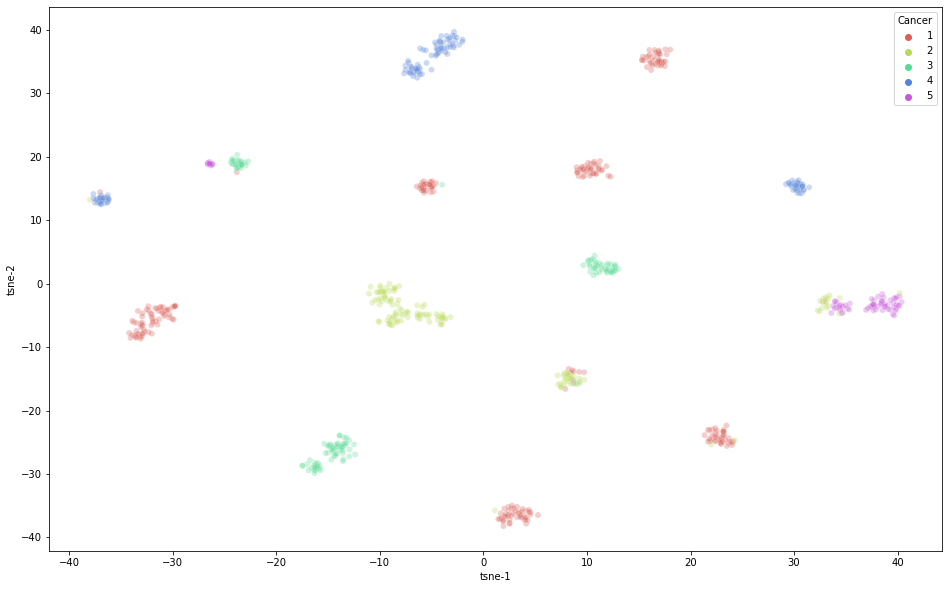

Perplexity: 30 LR: 200


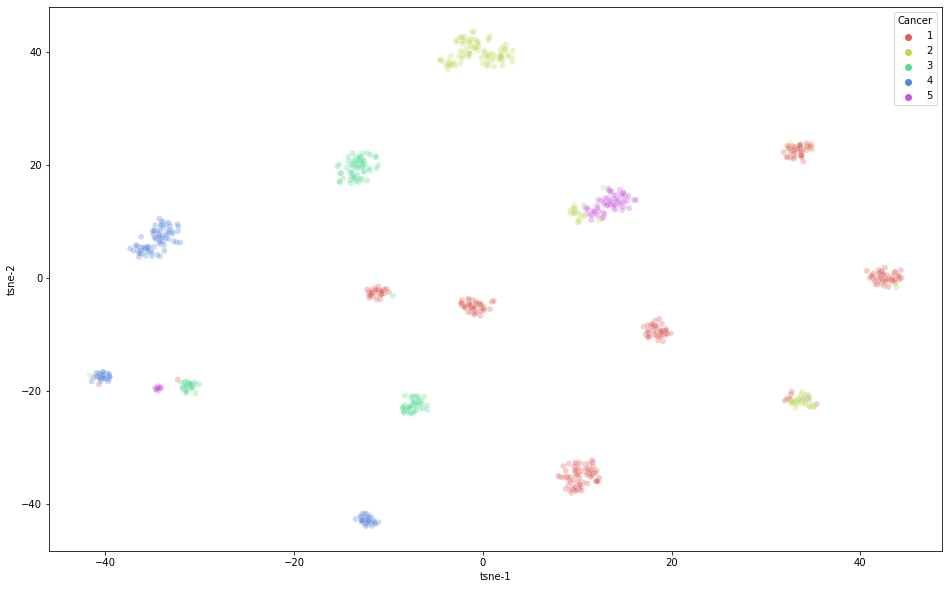

Perplexity: 30 LR: 500


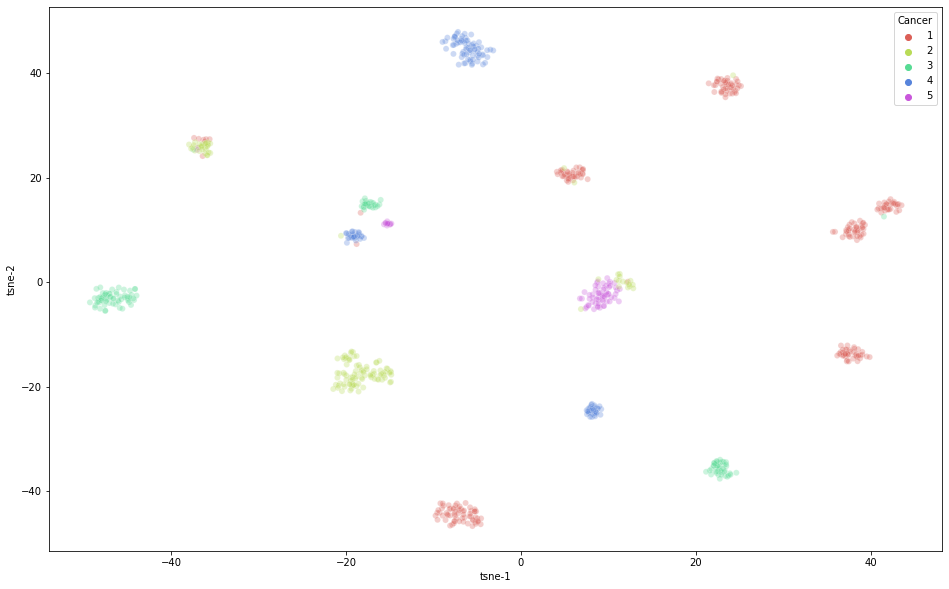

Perplexity: 60 LR: 50


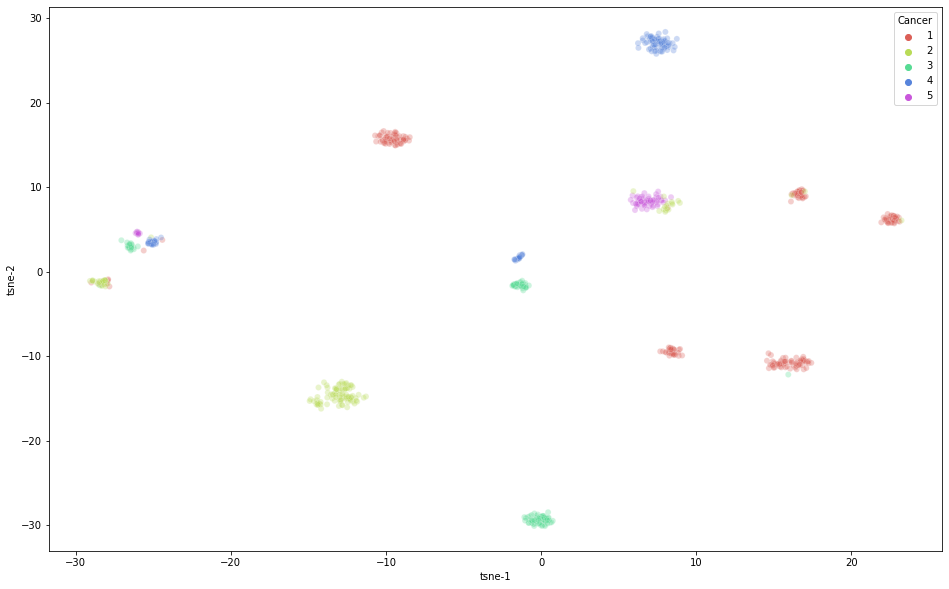

Perplexity: 60 LR: 200


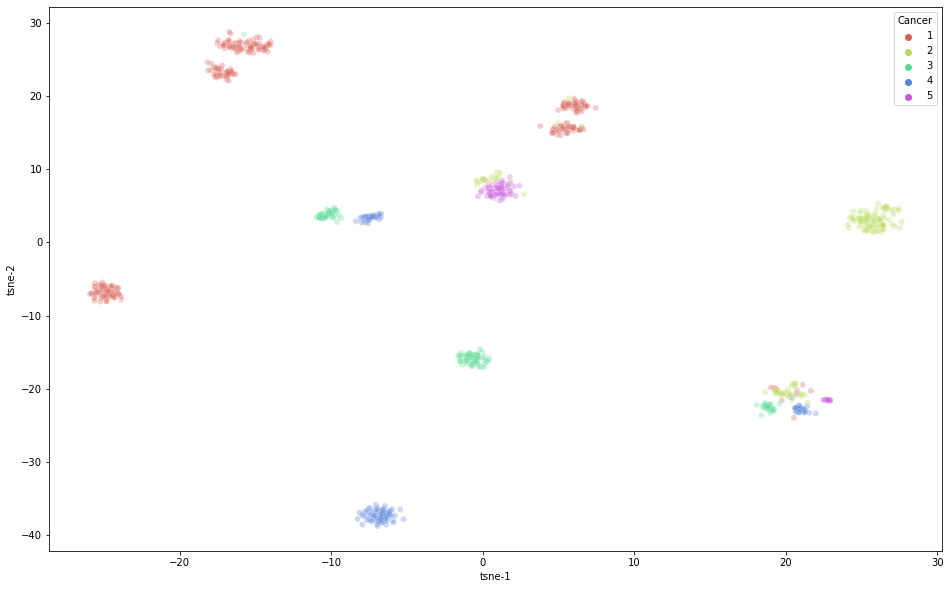

Perplexity: 60 LR: 500


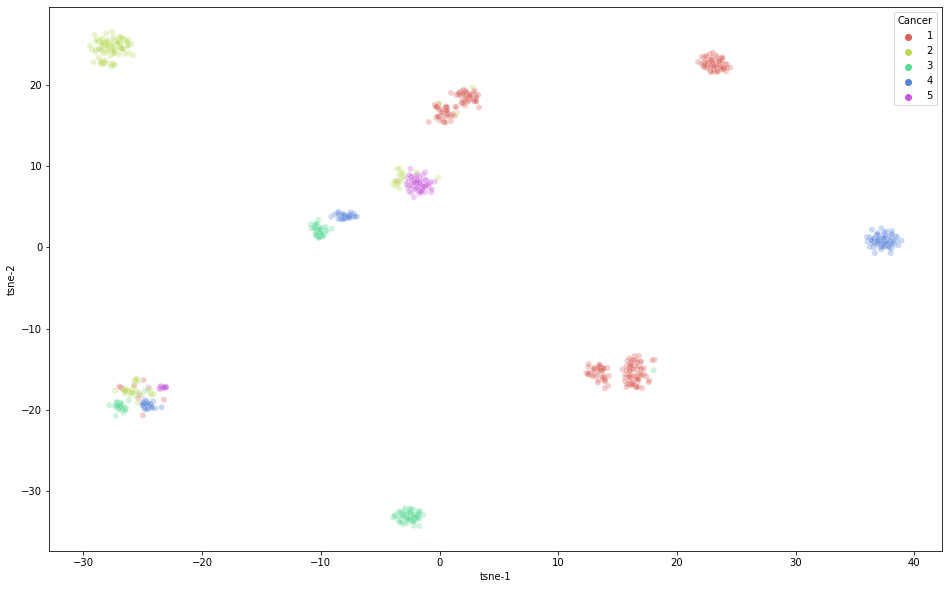

In [33]:
perplexities = [10, 20, 30, 60]
lr = [50, 200, 500]

for p in perplexities:
    for l in lr:
        tsne = TSNE(perplexity = p, learning_rate = l, n_components = 2)
        tsne_results = tsne.fit_transform(cancer)

        cancer["tsne-1"] = tsne_results[:,0]
        cancer["tsne-2"] = tsne_results[:,1]
        print(f'Perplexity: {p} LR: {l}')
        plt.figure(figsize=(16,10))
        sns.scatterplot(
        x="tsne-1", y="tsne-2",
        hue="Cancer",
        palette=sns.color_palette("hls", 5),
        data=cancer,
        legend="full",
        alpha=0.3
        )
        plt.show()

As seen above, it appears as though when both learning rate and perplexity go up, the clusters become more centralized and more distinct from each other

# 2c

In [34]:
conda install -c conda-forge umap-learn

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.01 Neighbors: 5


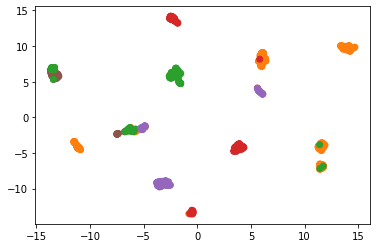

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.01 Neighbors: 10


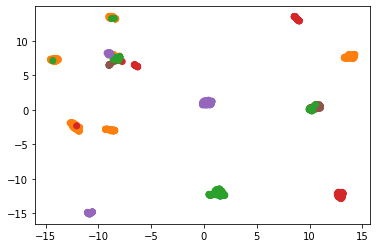

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.01 Neighbors: 15


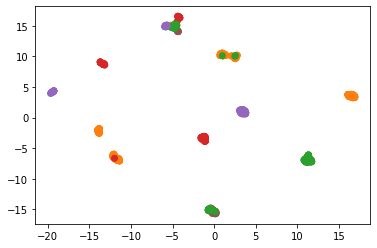

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.01 Neighbors: 30


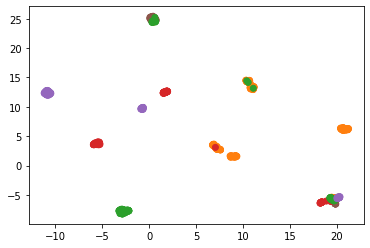

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.05 Neighbors: 5


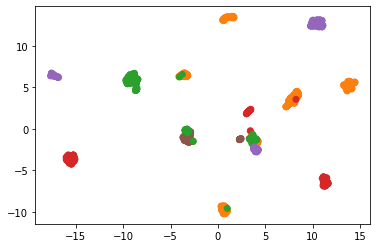

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.05 Neighbors: 10


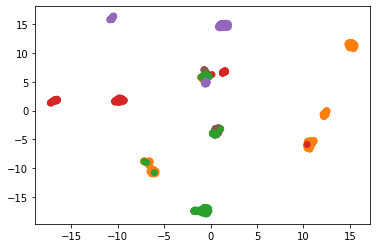

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.05 Neighbors: 15


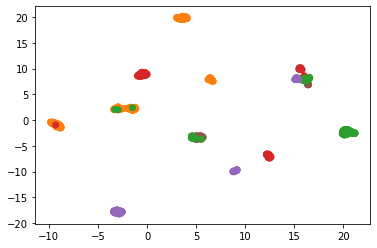

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.05 Neighbors: 30


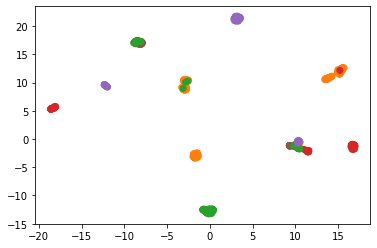

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.1 Neighbors: 5


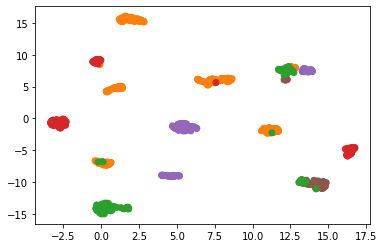

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.1 Neighbors: 10


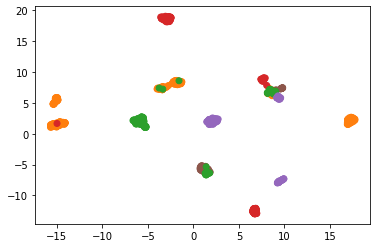

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.1 Neighbors: 15


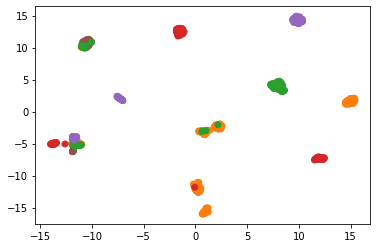

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.1 Neighbors: 30


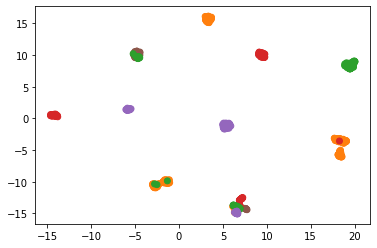

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.2 Neighbors: 5


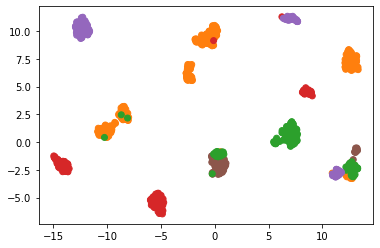

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.2 Neighbors: 10


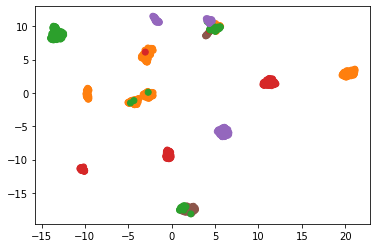

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.2 Neighbors: 15


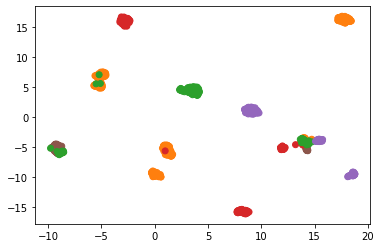

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Min Dist: 0.2 Neighbors: 30


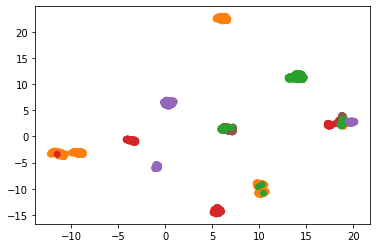

In [35]:
import umap

dists=[.01,.05,.1, .2]
neighbors = [5,10,15,30]

for d in dists:
    for n in neighbors:
        reducer = umap.UMAP(min_dist = d, n_neighbors = n)
        e = reducer.fit_transform(cancer)
        #print(e.shape)
        print(f'Min Dist: {d} Neighbors: {n}')
        plt.scatter(
        e[:,0],
        e[:,1],
        c=[sns.color_palette()[x] for x in cancer.Cancer]
        )
        plt.show()

It appears that when minimum distance goes up and neighbors go down, there is more consolidation of clusters and more clear seperation of the blobs. It is a little difficult to evaluate these choices, but I would set Min Dist to 0.1 and Neighbors to 30 for the best graph

# 2d

In [36]:
from sklearn.datasets import make_blobs
import time
n_obs = [10,100,1000,10000]
n_features = [10,30,100,300]
time_umap = []
time_sne = [] #to append times to

reducer = umap.UMAP()
tsne = TSNE()
for o in n_obs:
    for f in n_features:
        X,y = make_blobs(n_samples = o, n_features = f)
        start = time.time()
        e = reducer.fit_transform(X)
        time_umap.append(time.time()-start)
        #now t-sne
        
        start = time.time()
        tsne.fit_transform(X)
        time_sne.append(time.time()-start)

/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/Users/seanm/opt/anaconda3/lib/python3.9/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [37]:
obs = [10,10,10,10,100,100,100,100,1000,1000,1000,1000,10000,10000,10000,10000]
feats = [10,30,100,300,10,30,100,300,10,30,100,300,10,30,100,300]

times = pd.DataFrame(list(zip(obs, feats, time_umap, time_sne)), columns = ["Observations","Features","UMAP Time","t-SNE Time"])

times

,Observations,Features,UMAP Time,t-SNE Time
0,10,10,1.279202,2.571927
1,10,30,1.167832,2.187308
2,10,100,1.356038,1.777633
3,10,300,1.262466,2.032889
4,100,10,1.757286,3.856685
5,100,30,1.797388,5.732614
6,100,100,1.538757,5.015904
7,100,300,1.498334,5.905957
8,1000,10,2.701984,10.952919
9,1000,30,2.957510,9.566919


It seems that UMAP times scale relatively well regardless of features or observations. T-SNe, on the other hand, takes significantly longer with more observations. 